# Tests for equality of variance

Many parametric tests involving multiple groups assume homegeneity of variance among different groups, especially in ANOVA. In this notebook, I summarize some parametric and non-parametric methods to test the equality of variance.

Test one sample variance against another constant:
* Chi-square test for variance
* Wald test with bootstrap to estimate standard error of sample variance.

Test homogeneity of variance among groups:
* $F$-test of equality of variances
* Hartley test
* Bartlett's test
* Levene test
* permutation test
* Cochran's C test

In [174]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import tests_util
from  importlib import reload
reload(tests_util)
from tests_util import *

###  Chi-Square test for the variance
A chi-square test ( Snedecor and Cochran, 1983) can be used to test if the variance of a population is equal to a specified value. This test can be either a two-sided test or a one-sided test. This test assumes normality of the sample and use the fact following statistics:
$T = \sum_{i=1}^{N} (X_{i}-\bar{X})^2/\sigma_{0}^{2}$ follows a $\chi^2$ distribution with $N-1$ degree of freedom. 

Assumption:
* Each sample follows IID normal distribution.

#### Example, two tail chi-square test

chi2 test statistics T: 114.18086 and P-vale 0.00000081, power = 0.97838984
Reject null hypothesis at 95% confidence


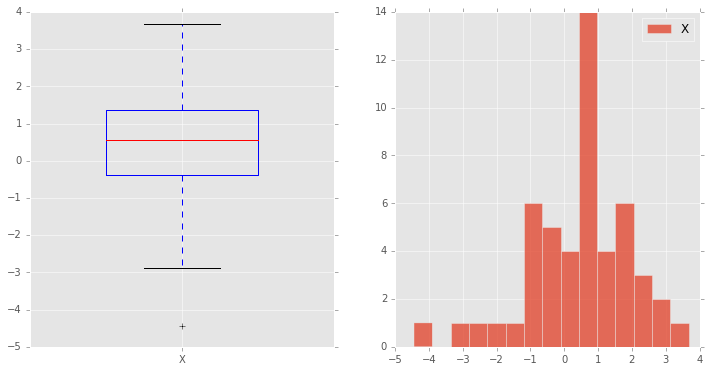

In [57]:
sigma_0 = 1
sigma   = 1.5
N  = 50
df = N-1
X  = stats.norm.rvs(scale=sigma, size = N)
plot_dignostics([X],['X'], test=None)
T = ((X - X.mean())**2).sum()/sigma_0**2
pvalue = (1 - stats.chi2.cdf(T, df=df))*2
alpha =  0.05
# rejection region:
lo = stats.chi2.ppf(alpha/2, df)
hi = stats.chi2.ppf(1-alpha/2, df)

# power
power = 1 + stats.chi2.cdf(lo, df, scale=sigma_0**2/sigma**2) - stats.chi2.cdf(hi, df, scale=sigma_0**2/sigma**2)

test='chi2'
print('%s test statistics T: %8.5f and P-vale %10.8f, power = %10.8f' % (test, T, pvalue, power))
if pvalue<0.05:
    print('Reject null hypothesis at 95% confidence')
else:
    print('Fail to reject null hypothesis at 95% confidence')

### Wald test with bootstrap

Sample variance $S^2$ is the __plug-in estimator__ of true variance $\sigma^2$. As sample size is big, $S^2\sim N(\sigma^2, \hat{se}^2)$, where $\hat{se}$ is the standard error. Bootstrap is used in this case to obtain the standard error empirically.

In [58]:
batch_size = 1000
var_batches = np.zeros((batch_size,))
for i in range(batch_size):
    x_sample = np.random.choice(X, N)
    var_batches[i] = x_sample.var(ddof=1)
se = var_batches.std(ddof=1)

# wald statistic
W  =  (X.var(ddof=1) - sigma_0**2)/se
pvalue = (1 - stats.norm.cdf(W))*2

# rejection region:
lo = stats.norm.ppf(alpha/2)
hi = stats.norm.ppf(1-alpha/2)

power = 1 + stats.norm.cdf(lo, loc=sigma**2-sigma_0**2) - stats.norm.cdf(hi, loc=sigma**2-sigma_0**2)

test = 'Wald with bootstrap'
print('%s test statistics T: %8.5f and P-vale %10.8f, power = %10.8f' % (test, W, pvalue, power))
if pvalue<0.05:
    print('Reject null hypothesis at 95% confidence')
else:
    print('Fail to reject null hypothesis at 95% confidence')

Wald with bootstrap test statistics T:  2.31363 and P-vale 0.02068826, power = 0.23952699
Reject null hypothesis at 95% confidence


Bootstrap is not as powerful as chi-square test when the data is truly normaly distributed. However, bootstrap still applies when the data is not normally distributed.

### $F$-test of equality of variances 
$F$-test of equality of variances is a test for the null hypothesis that two __normal__ populations have the same variance.

Let $X_1, ..., X_n$ and $Y_1, ..., Y_m$ are iid samples from two normally distributed populations. Let

$S_{X}^2 = \frac{1}{n-1}\sum_{i=1}^{n}(X_i-\bar{X})^2$ and $S_{Y}^2 = \frac{1}{m-1}\sum_{i=1}^{m}(Y_i-\bar{Y})^2$ 

be the sample variances. Then the test statistic:
$F=\frac{S_{X}^2}{S_{Y}^2}$ has a $F$-distribution with $n-1$ and $m-1$ degree of freedom if the null hypothesis is true.

This F-test is known to be extremely sensitive to non-normality, so Levene's test, Bartlett's test, or the Brown–Forsythe test are better tests for testing the equality of two variances.

An related test is [Hartley's test](https://en.wikipedia.org/wiki/Hartley%27s_test), which uses $F_{max}=\max(S_{j}^2)/\min(S_{j}^2)$ as a test statistics. Hartley's test is also extremely sensitive to deviation from normality.

### Levene test for equality of variances

This can be valided by performing [Levene's test](https://en.wikipedia.org/wiki/Levene%27s_test). When the underlying distribution is well approximated by normal distribution, [Bartlett's test](https://en.wikipedia.org/wiki/Bartlett%27s_test) can be applied. However, Levene test is more robust than Bartlett's test when assumption of normality is violated.

More reference of Levene test can be found here: http://www.itl.nist.gov/div898/handbook/eda/section3/eda35a.htm.

### Permutation test

We can always use permutation test, which has sample distribution assumption. Given multiple samples, permute all the samples after removing its group mean. We can compute any statistic that measures the deviation of group variances to mean variances of all the groups. For example, we can use:
$\sum_{i=1}^K (SS_i -\bar{SS})^2/K-1$ where $K$ is the number of groups. Other test statistics can also be applied.

Permutation exploit the symmetry of among the compared groups under null hypothesis (equal variance).

#### Example of using different test:

========   TEST OF EQUAL VARIANCE   =======
f test statistics T:  1.86922 and P-vale 0.00207430
Reject null hypothesis at 95% confidence
========   TEST OF EQUAL VARIANCE   =======
bartlett test statistics T: 11.39284 and P-vale 0.00335797
Reject null hypothesis at 95% confidence
========   TEST OF EQUAL VARIANCE   =======
levene test statistics T:  1.54128 and P-vale 0.21581510
Fail to reject null hypothesis at 95% confidence
Permutation test statistics T:  0.52356 and P-vale 0.02400000
Reject null hypothesis at 95% confidence


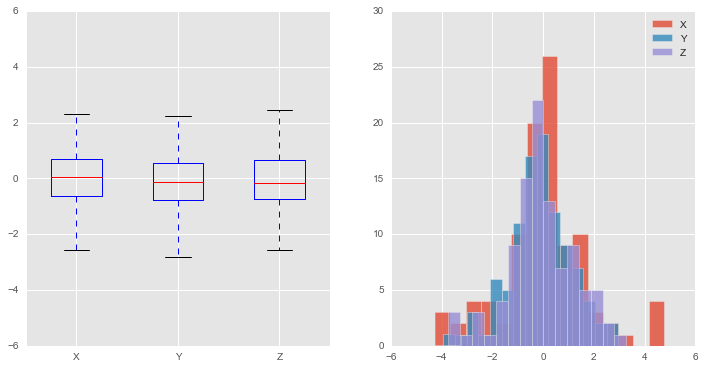

In [134]:
# X = stats.norm.rvs(size = 100)
# Y = stats.norm.rvs(size = 100)
X = stats.t.rvs(df=3, size = 100)
Y = stats.t.rvs(df=4, size = 100)
Z = stats.t.rvs(df=5, size = 100)
T,pvalue=homo_vars([X, Y], test = 'f')
T,pvalue=homo_vars([X, Y, Z], plot=True, labels = ['X','Y','Z'], bins=15, test = 'bartlett')
T,pvalue=homo_vars([X, Y, Z], test = 'levene')

#define test statistic function
def stat_fun(samples):
    s = list(map(lambda x: np.var(x,ddof=1), samples))
    return np.var(s, ddof=1)

def stat_fun2(samples):
    X = np.vstack(samples).T
    s = X.var(ddof=1,axis=0)
    return s.max()/s.sum()
samples = [X, Y, Z]

# permutation test
ptest = PermTest(samples, stat_fun)
ptest.test(size=1000)

This example shows that levene's test and permutation test are more robust when normality is violated (I used $t$ distribution to generate the samples). While two samples are generated from the same $t$-distribution, Bartlett and F test reject the null hypothesis (because of the the violation of nomality assumption) while levene's test fail to reject the null.

### Cochran's C test
Cochran's C test is designed to detect if there's an outlier variance, which is significantly larger than variances in other groups. 

The test statistic:

$C = \frac{S_{max}^2}{\sum_{i=1}^{k} S_{i}^2}$

Details can be found:https://en.wikipedia.org/wiki/Cochran's_C_test.

$C_{UL}(\alpha, n, k)=\left[1 + \frac{k-1}{FPPF(1-\alpha/k,(n-1),(k-1)(n-1))} \right]^{-1}$

where $\alpha$ is the significance level (e.g. 0.01, 0.025, 0.05, etc.), $n$ is the number of data points per group, $k$ is the number of groups.

Cochran's C test was generalized to include unbalanced designs, one-sided lower limit tests and two-sided tests at any significnace level $\alpha$ by [R.U.E. 't Lam (2010)](http://rtlam.blogspot.com), which the author names as $G$-test. Both $C$ and $G$ test assumes that the data in each group are normally distributed.

I implemented this test in ```tests_util.py```.

=========  Cochran's C test  =========
# data per group  : 50
# of groups       : 10
Largest variance  : 1.805648
Sum of variances  : 10.122501
Mean variance     : 1.012250
Significance level: 0.050
Test statistic    : 0.178380
Critical value    : 0.155168
Diagnostic: reject null


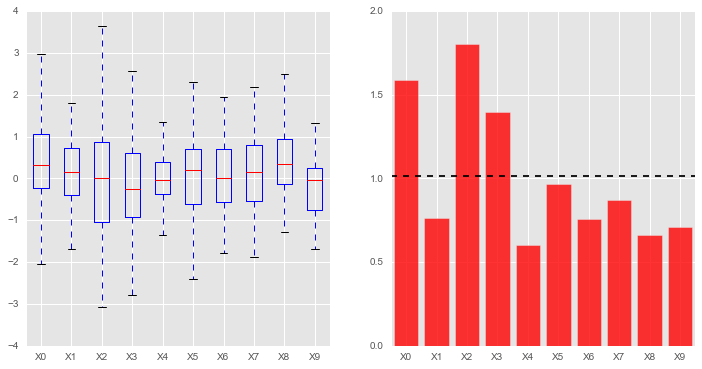

In [176]:
n = 50
k = 10
samples = []
scales = stats.uniform.rvs(loc=0.8, scale=0.5, size=k)

for i in range(k):
    samples.append(stats.norm.rvs(scale=scales[i],size = n))

_ =cochranC(*samples,alpha=0.05, plot=True)